# Handwritten digit classification

The goal is to classify handwritten digits into 10 classes using dimensionality reduction and a classical classifier.

Ideally, the classification should be visualizable in a 2D graph at the end (hence the dimensionality reduction).

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

from umap import UMAP
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Data loading and visualization

This rather balanced dataset contains 1797 handwritten digits as 8x8 pixel images.

Thus, there are 8x8=64 features for each image (_i.e._, the pixel intensities).

In [13]:
# Load data
digits = datasets.load_digits()
X, y, images = digits.data, digits.target, digits.images
feature_names, label_names = digits.feature_names, digits.target_names.tolist()
label_names = [str(x) for x in label_names]
n_samples, n_features = X.shape
n_classes = len(label_names)

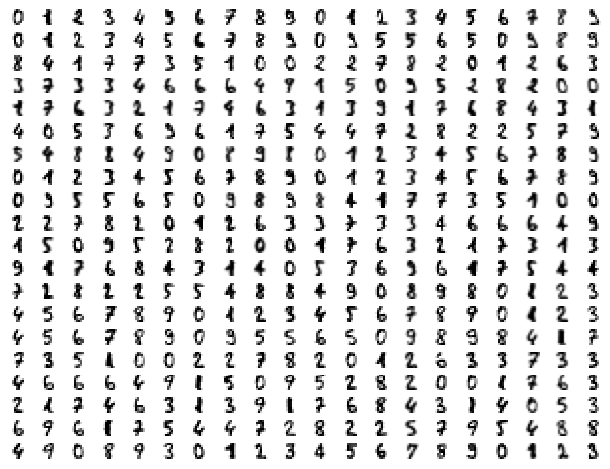

In [14]:
# Visualize some images from the dataset
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.savefig(os.path.join(output_directory, '1_some_digits.png'),
            bbox_inches='tight', dpi=600)
plt.show()

## Train/test split and feature scaling

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Dimensionality reduction

### Principal component analysis (PCA)

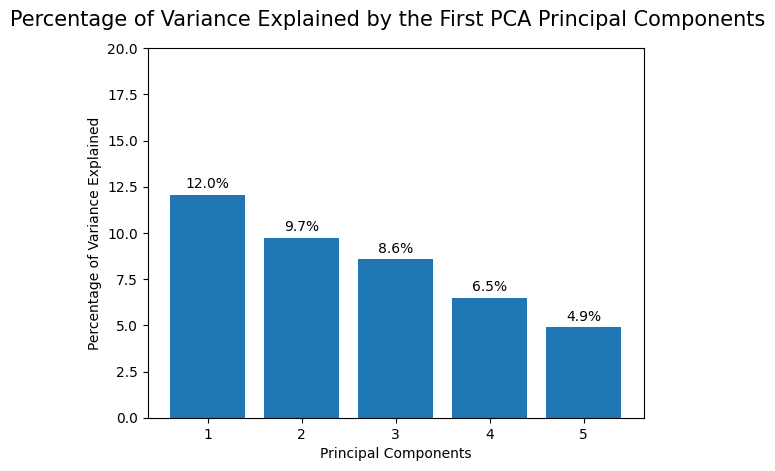

In [16]:
# Check if data is a good candidate for PCA reduction
n_components_plot = 5  # For plotting purposes only
pca = PCA(n_components=n_components_plot)
pca.fit(X_train_scaled)

fig, ax = plt.subplots()
p = ax.bar(np.arange(n_components_plot),
           pca.explained_variance_ratio_*100)
ax.bar_label(p, fmt=lambda x: f'{x:.1f}%', padding=3)
plt.xticks(ticks=np.arange(n_components_plot),
           labels=[str(i+1) for i in np.arange(n_components_plot, dtype=np.int32)])
plt.ylim([0, 20])
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variance Explained')
plt.suptitle('Percentage of Variance Explained by the First PCA Principal Components',
             y=0.96, fontsize=15)
plt.savefig(os.path.join(output_directory, '2_pca_first_principal_components.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The percentage of explained variance is spread out across multiple principal components, with the first 4 components barely reaching 50% of explained variance. 
- Thus, PCA may not be quite suitable for the problem at hand, especially if we want to visualize the final classification in a 2D graph. 

This is confirmed in the figure below, showing the PCA decomposition of the training set wherein no clear digits cluster are teased apart. 

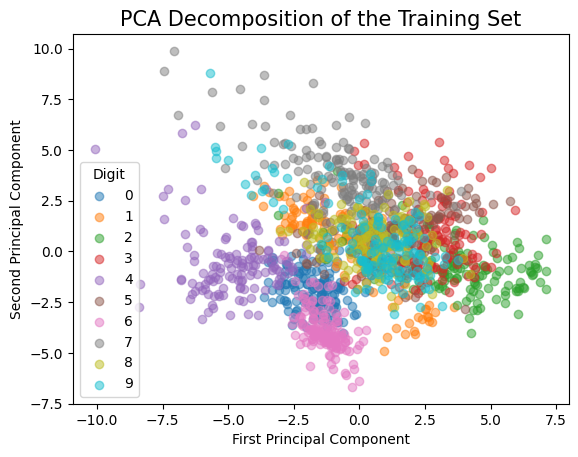

In [17]:
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)

for target_class in range(n_classes): 
    plt.scatter(
        x = X_train_scaled_pca[y_train == target_class, 0],
        y = X_train_scaled_pca[y_train == target_class, 1],
        label = f"{target_class}", alpha=0.5
    )
plt.legend(title='Digit')
plt.title('PCA Decomposition of the Training Set', fontsize=15)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig(os.path.join(output_directory, '3_pca_training_set.png'),
            bbox_inches='tight', dpi=600)
plt.show()

### Uniform Manifold Approximation and Projection (UMAP)

Let us try the Uniform Manifold Approximation and Projection (UMAP) instead.

In [18]:
umap = UMAP(min_dist=0.0,
            n_components=2,
            n_jobs=1,
            random_state=42)
X_train_scaled_umap = umap.fit_transform(X_train_scaled)
X_test_scaled_umap = umap.transform(X_test_scaled)

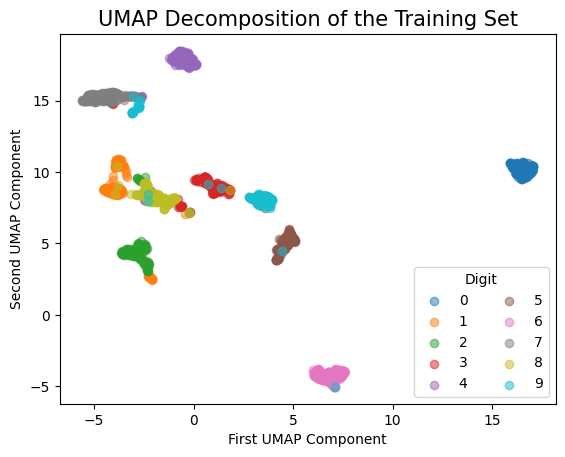

In [19]:
for target_class in range(n_classes): 
    plt.scatter(
        x = X_train_scaled_umap[y_train == target_class, 0],
        y = X_train_scaled_umap[y_train == target_class, 1],
        label = f"{target_class}", alpha = 0.5
    )
plt.legend(title='Digit', ncol=2)
plt.title('UMAP Decomposition of the Training Set', fontsize=15)
plt.xlabel('First UMAP Component')
plt.ylabel('Second UMAP Component')
plt.savefig(os.path.join(output_directory, '4_umap_training_set.png'),
            bbox_inches='tight', dpi=600)
plt.show()

Even though it is non-trivial to estimate the variance explained by a non-linear decomposition such as UMAP, it looks more promising than PCA for classification purposes.

## Radial support vector machine

Given some of the digit clusters above are disjoint, a radial support vector classifier may be best suited for the task. We perform hyperparameter tuning using cross-validated grid search. Even though the dataset is rather balanced, `class_weight` is set to `'balanced'`to mitigate any imbalance effect. 

In [20]:
# Hyperparameter tuning using cross-validated grid search
param_grid = {
    'C': [0.1, 0.5, 1, 10, 50, 100, 150],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    estimator=SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=42),
    param_grid=param_grid,
    scoring='accuracy'
)
grid_search.fit(X_train_scaled_umap, y_train)

# Best estimator
model_svm_radial = grid_search.best_estimator_
model_svm_radial

SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.87      0.96      0.92        28
           2       0.97      0.94      0.95        33
           3       0.97      0.94      0.96        34
           4       0.96      1.00      0.98        46
           5       0.96      0.96      0.96        47
           6       0.97      1.00      0.99        35
           7       1.00      0.94      0.97        34
           8       0.96      0.87      0.91        30
           9       0.93      0.95      0.94        40

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



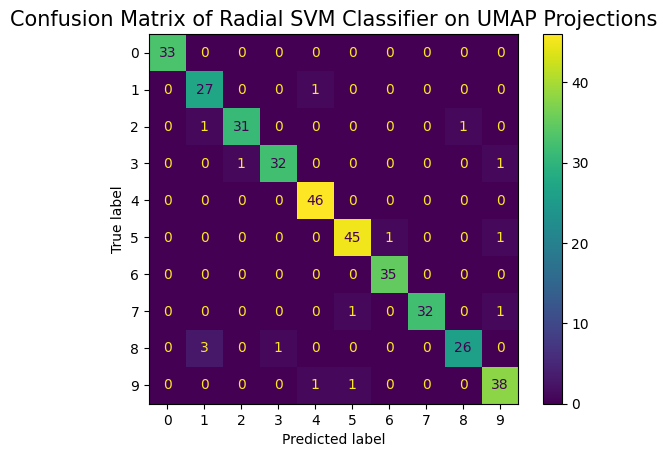

In [21]:
# Evaluation
y_pred = model_svm_radial.predict(X_test_scaled_umap)
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(
    confusion_mat,
    display_labels=label_names)
disp.plot()
plt.title('Confusion Matrix of Radial SVM Classifier on UMAP Projections', fontsize=15)
plt.savefig(os.path.join(output_directory, '5_radial_svm_umap_confusion_matrix.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The radial SVM classifier reaches an accuracy of 96% on the UMAP projections of the testing set. 

Given the complexity of the classifier's decision boundary, we do not visualize it but rather plot the projections that were correctly or incorrectly predicted for each digit below. For instance:
- "Good 0" represents true 0s that were correctly predicted.
- "Bad 0" represents true 0s that were incorrectly predicted.

In the case of a badly predicted projection, the actual model prediction can be inferred from the above confusion matrix and from the nearest-neighbor projections.

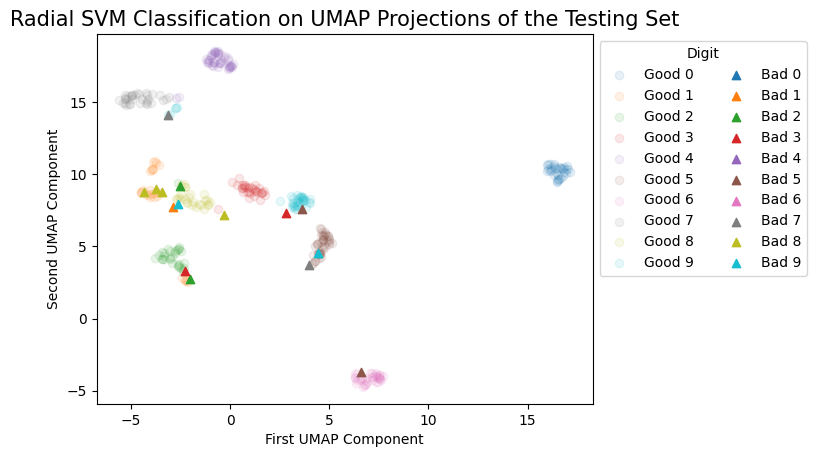

In [22]:
# The for loop is split to ensure consistent color coding
for target_class in range(n_classes): 
    # Correctly classified digits
    good_idx = np.logical_and(y_test == target_class,
                              y_pred == target_class)   
    plt.scatter(
        x=X_test_scaled_umap[good_idx, 0],
        y=X_test_scaled_umap[good_idx, 1],
        label=f"Good {target_class}",
        alpha=0.1
    )

for target_class in range(n_classes): 
    # Badly classified digits
    bad_idx = np.logical_and(y_test == target_class,
                             y_pred != target_class) 
    plt.scatter(
        x=X_test_scaled_umap[bad_idx, 0],
        y=X_test_scaled_umap[bad_idx, 1],
        label=f"Bad {target_class}",
        marker='^',
        alpha=1
    )

plt.gca().legend(title='Digit', ncol=2, bbox_to_anchor=(1, 1))
plt.title('Radial SVM Classification on UMAP Projections of the Testing Set', fontsize=15)
plt.xlabel('First UMAP Component')
plt.ylabel('Second UMAP Component')
plt.savefig(os.path.join(output_directory, '6_radial_svm_umap_predictions.png'),
            bbox_inches='tight', dpi=600)
plt.show()